In [376]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [377]:
import warnings
warnings.filterwarnings('ignore')

In [378]:
matplotlib.rcParams.update({'font.size': 14})

In [379]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
   
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

    plt.figure(figsize=(18,10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Пути к директориям и файлам

In [380]:
TRAIN_DATASET_PATH = 'project_task/train.csv' # y_train, y_valid
TEST_DATASET_PATH = 'project_task/test.csv'

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [381]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


In [382]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.555693,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B


In [383]:
train_df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

In [384]:
# test_id = test_df["Id"]
# pred_df = pd.DataFrame()
# pred_df["Id"] = test_id
# pred_df["Price"] = np.random.randint(0, 1e6, size=test_id.shape[0])
# assert pred_df.shape[0] == 5000, f"Real pred-shape = {pred_df.shape[0]}, Expected pred-shape = 5000"

# pred_df.to_csv("./predictions_.csv", index=False)

### Разбиение на train и valid

In [385]:
feature_names = ['Id','DistrictId','Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2', 'Price']

#new_feature_names = ['IsDistrictLarge', 'MedPriceByDistrict']

target_name = 'Price'

In [386]:
X = train_df[feature_names]
y = train_df[target_name]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21) # test_size=0.33 ????
X_valid = X_valid.drop('Price', axis=1)

In [387]:
X_train.shape

(6700, 20)

In [388]:
X_valid.shape

(3300, 19)

In [389]:
X_train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [390]:
X_train.dtypes.value_counts()

int64      9
float64    8
object     3
dtype: int64

In [391]:
X_train['Id'] = X_train['Id'].astype(str)
X_train['DistrictId'] = X_train['DistrictId'].astype(str)

## Обзор данных

### Целевая переменная

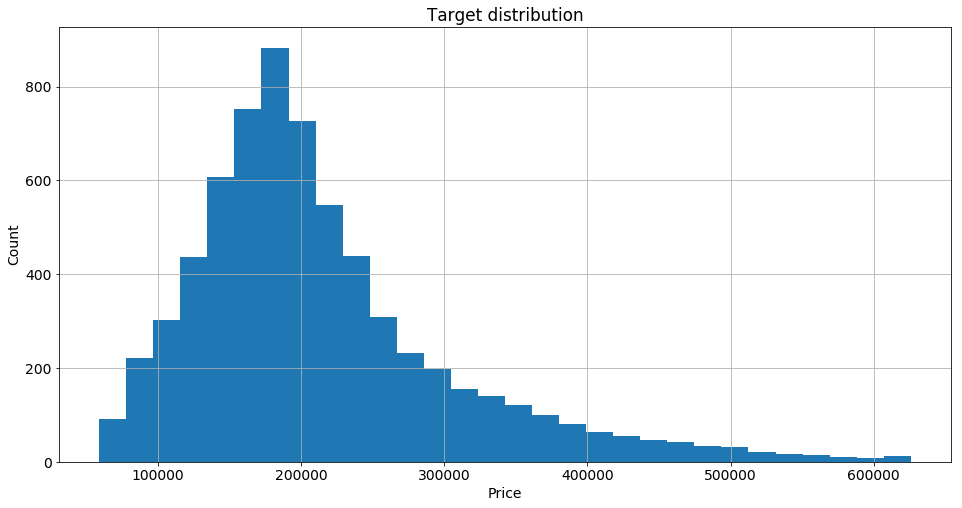

In [392]:
plt.figure(figsize = (16, 8))

X_train['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

### Количественные переменные

In [393]:
X_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,6700.000000,6700.000000,5260.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,3481.000000,6700.000000,6700.000000,6700.000000
mean,1.882537,56.081497,37.415591,6.438060,8.494776,12.647463,1985.154776,0.118740,24.670597,5333.197463,7.952985,1150.579718,1.332836,4.222985,213872.986633
std,0.815633,20.468093,104.661936,34.688095,5.220311,6.803397,40.872731,0.119600,17.459441,3977.675264,23.718438,1021.277009,1.510859,4.812391,92638.972848
min,0.000000,1.988943,0.370619,0.000000,1.000000,0.000000,1912.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.798893,22.711308,1.000000,4.000000,9.000000,1973.000000,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153994.680334
50%,2.000000,52.083642,32.505331,6.000000,7.000000,13.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192817.509808
75%,2.000000,65.790145,44.768302,9.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249080.956886
max,10.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,4968.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,625820.041178


### Категориальные признаки

In [394]:
def cat_features(df):
    cat_colnames = df.select_dtypes(include='object').columns.tolist()
    for cat_colname in cat_colnames[2:]:
        print(str(cat_colname) + '\n\n' + str(X_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')
    
    
    return df


### Обработка выбросов

In [395]:
def df_fix(df):
    df.loc[df['Rooms'].isin([0, 10]), 'Rooms'] = df['Rooms'].median()
    df.loc[df['Square'] > df['Square'].quantile(.99), 'Square'] = df['Square'].median()  
    df.loc[df['Square'] < df['Square'].quantile(.01), 'Square'] = df['Square'].median()
    df.loc[df['LifeSquare'].isna(), 'LifeSquare'] = df['LifeSquare'].median()
    df.loc[df['LifeSquare'] > df['LifeSquare'].quantile(.99), 'LifeSquare'] = df['LifeSquare'].median()
    df.loc[df ['LifeSquare'] < df['LifeSquare'].quantile(.01), 'LifeSquare'] = df['LifeSquare'].median()
    df.loc[X_train['KitchenSquare'].isnull(), 'KitchenSquare'] = df['KitchenSquare'].median
    df.loc[X_train['KitchenSquare'] < 3, 'KitchenSquare'] = 3
    df.loc[X_train['KitchenSquare'] > 25, 'KitchenSquare'] = df['KitchenSquare'].median()

    df.loc[df['Square']< df["KitchenSquare"] + df["LifeSquare"], 'Square'] =  df["KitchenSquare"] + df["LifeSquare"]
    df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df['HouseFloor'].median()
    floor_outliers = df[X_train['Floor'] > df['HouseFloor']].index
    df.loc[floor_outliers, 'Floor'] = df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))
    df.loc[X_train['HouseYear'] > 2020, 'HouseYear'] = 2020
    df.loc[X_train['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()
    
    return df
    

In [396]:
X_train['Rooms'].value_counts()

2.0     2633
1.0     2485
3.0     1467
4.0       95
5.0       13
0.0        5
10.0       1
6.0        1
Name: Rooms, dtype: int64

In [397]:
X_train['Rooms'].shape

(6700,)

In [398]:
X_train['Rooms'].median()

2.0

In [399]:
df_fix(X_train)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9239,14100,93,1.0,39.4582,21.630224,8,9,17.0,1985,0.050900,B,B,43,10621,1,30.0,2,3,B,130416.073182
6930,13906,26,1.0,57.0886,23.298211,10,4,30.0,2014,0.000000,B,B,36,6714,2,2672.0,0,2,B,298237.106464
8136,715,44,1.0,32.7776,22.448450,5,8,9.0,1967,0.036122,B,B,24,4378,0,1036.0,1,1,B,170455.930747
3424,3518,37,1.0,37.7521,20.140014,10,6,15.0,1976,0.127812,B,B,28,7287,5,320.0,1,3,B,167876.802185
6518,10941,23,1.0,35.5053,32.505331,3,9,12.0,1977,0.034656,B,B,0,168,0,900.0,0,0,B,76228.918314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9336,7845,8,1.0,38.4764,23.803304,9,14,14.0,1971,0.092291,B,B,21,4346,2,165.0,1,2,B,177869.810963
48,7596,23,1.0,58.808,46.807989,12,3,9.0,1977,0.014073,B,B,2,475,0,900.0,0,0,B,96029.167877
8964,13776,1,3.0,74.1327,45.351233,10,10,17.0,2009,0.025609,B,B,33,5261,0,240.0,3,1,B,200265.870270
5944,15646,46,2.0,63.9114,33.784613,12,2,17.0,2004,0.188784,B,B,31,6137,4,900.0,0,1,B,353882.050594


In [400]:
X_train['Rooms'].shape

(6700,)

In [401]:
X_train['Square'].sort_values().unique()

array([29.4128728676612, 29.415989887335463, 29.5546026466777, ...,
       117.30002431190924, 117.37074612292618, 117.71455103699681],
      dtype=object)

In [402]:
X_train['Square'][X_train['Square'] < 10]

Series([], Name: Square, dtype: object)

In [403]:
 X_train['Square'].quantile(.99)

103.46127473154915

In [404]:
X_train['Square'].quantile(.01)

31.798606847381354

In [405]:
X_train['Square'].median()

52.13029603278556

In [406]:
X_train['Square']

9239    39.4582
6930    57.0886
8136    32.7776
3424    37.7521
6518    35.5053
         ...   
9336    38.4764
48       58.808
8964    74.1327
5944    63.9114
5327    39.3143
Name: Square, Length: 6700, dtype: object

In [407]:
X_train['Square'].shape

(6700,)

In [408]:
X_train.describe()

,Rooms,LifeSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000
mean,1.882836,34.627668,7.411343,12.990896,1984.714776,0.118740,24.670597,5333.197463,7.952985,1030.189254,1.332836,4.222985,213872.986633
std,0.807953,13.089533,5.040015,6.476506,18.504176,0.119600,17.459441,3977.675264,23.718438,746.657593,1.510859,4.812391,92638.972848
min,1.000000,3.645893,1.000000,1.000000,1912.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,59174.778028
25%,1.000000,26.695164,3.000000,9.000000,1973.000000,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153994.680334
50%,2.000000,32.505331,6.000000,13.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192817.509808
75%,2.000000,39.970051,11.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1015.000000,2.000000,6.000000,249080.956886
max,6.000000,89.554843,42.000000,117.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,625820.041178


In [409]:
X_train['LifeSquare'].sort_values(ascending=False)

3560    89.554843
4802    89.274642
2835    88.934494
2299    88.931509
8292    88.820781
          ...    
3447     3.823980
4899     3.769436
2906     3.668460
8061     3.666085
9316     3.645893
Name: LifeSquare, Length: 6700, dtype: float64

In [410]:
X_train['KitchenSquare'].sort_values(ascending=False)

7249    25
9910    25
2656    23
8390    22
622     22
        ..
2223     3
2813     3
9166     3
7719     3
7570     3
Name: KitchenSquare, Length: 6700, dtype: object

In [411]:
X_train['LifeSquare'].sort_values(ascending=False)

3560    89.554843
4802    89.274642
2835    88.934494
2299    88.931509
8292    88.820781
          ...    
3447     3.823980
4899     3.769436
2906     3.668460
8061     3.666085
9316     3.645893
Name: LifeSquare, Length: 6700, dtype: float64

In [412]:
X_train['KitchenSquare'].median()

6.0

In [413]:
X_train['KitchenSquare'].sort_values(ascending=True)

7570     3
7719     3
9166     3
2813     3
2223     3
        ..
622     22
8390    22
2656    23
9910    25
7249    25
Name: KitchenSquare, Length: 6700, dtype: object

### HouseFloor, Floor

In [414]:
X_train['HouseFloor'].sort_values().unique()

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  36.,
        37.,  39.,  40.,  45.,  47.,  48.,  99., 117.])

In [415]:
X_train['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 32, 42], dtype=int64)

### HouseYear

In [416]:
X_train['HouseYear'].value_counts().sort_index()

1912      2
1914      1
1916      1
1917      2
1918      5
       ... 
2016    218
2017    192
2018    118
2019     51
2020     14
Name: HouseYear, Length: 93, dtype: int64

### Обработка пропусков

In [417]:
def new_cat_features(df):
    df['Ecology_2_bin'] = df['Ecology_2'].replace({'A':0, 'B':1})
    df['Ecology_3_bin'] = df['Ecology_3'].replace({'A':0, 'B':1})
    df['Shops_2_bin'] = df['Shops_2'].replace({'A':0, 'B':1})
    
    #df.drop(['Ecology_2', 'Ecology_3', 'Shops_2'], axis=1).head()
    
    return df

In [418]:
# def drop(df):
   
#     df.drop(['Ecology_2', 'Ecology_3', 'Shops_2'], axis=1).head()
    
#     return df

In [419]:
new_cat_features(X_train)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
9239,14100,93,1.0,39.4582,21.630224,8,9,17.0,1985,0.050900,...,10621,1,30.0,2,3,B,130416.073182,1,1,1
6930,13906,26,1.0,57.0886,23.298211,10,4,30.0,2014,0.000000,...,6714,2,2672.0,0,2,B,298237.106464,1,1,1
8136,715,44,1.0,32.7776,22.448450,5,8,9.0,1967,0.036122,...,4378,0,1036.0,1,1,B,170455.930747,1,1,1
3424,3518,37,1.0,37.7521,20.140014,10,6,15.0,1976,0.127812,...,7287,5,320.0,1,3,B,167876.802185,1,1,1
6518,10941,23,1.0,35.5053,32.505331,3,9,12.0,1977,0.034656,...,168,0,900.0,0,0,B,76228.918314,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9336,7845,8,1.0,38.4764,23.803304,9,14,14.0,1971,0.092291,...,4346,2,165.0,1,2,B,177869.810963,1,1,1
48,7596,23,1.0,58.808,46.807989,12,3,9.0,1977,0.014073,...,475,0,900.0,0,0,B,96029.167877,1,1,1
8964,13776,1,3.0,74.1327,45.351233,10,10,17.0,2009,0.025609,...,5261,0,240.0,3,1,B,200265.870270,1,1,1
5944,15646,46,2.0,63.9114,33.784613,12,2,17.0,2004,0.188784,...,6137,4,900.0,0,1,B,353882.050594,1,1,1


In [420]:
X_train = X_train.drop(['Ecology_2', 'Ecology_3', 'Shops_2'], axis=1).head()

In [421]:
len(X_train) - X_train.count()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Price            0
Ecology_2_bin    0
Ecology_3_bin    0
Shops_2_bin      0
dtype: int64

In [422]:
X_train['Healthcare_1'].head()

9239      30.0
6930    2672.0
8136    1036.0
3424     320.0
6518     900.0
Name: Healthcare_1, dtype: float64

## Построение новых признаков (feature engineering)

In [423]:
# def df_price_per_sqm_in_dr(df):
#     info_by_district_id = df.groupby(['DistrictId', 'HouseYear'], as_index=False).agg(
#         {'Price': 'median', 'Square': 'mean'}).rename(
#         columns={'Price':'MedPriceByDistrict', 'Square': 'MeanSquareByDistrict'})

#     info_by_district_id['mean_price_per_sqm_in_dr'] = info_by_district_id['MedPriceByDistrict'] \
#         / info_by_district_id['MeanSquareByDistrict']
#     info_by_district_id.drop(
#         ['MedPriceByDistrict', 'MedSquareByDistrict'], axis=1, inplace=True)

#     df = pd.merge(df, info_by_district_id, on=[
#                   'DistrictId', 'HouseYear'], how='left')
    
    
#     return df

# def df_price_per_room_in_dr(df):
#     info_by_district_id = df.groupby(['DistrictId', 'HouseYear'], as_index=False).agg(
#         {'Price': 'median'}).rename(
#         columns={'Price':'MedPriceByDistrict'})

#     #info_by_district_id['mean_price_per_room_in_dr'] = info_by_district_id['MedPriceByDistrict'] \
#         #/ info_by_district_id['MeanSquareByDistrict']
#     #info_by_district_id.drop(
#         #['MedPriceByDistrict'], axis=1, inplace=True)

#     df = pd.merge(df, info_by_district_id, on=[
#                   'DistrictId', 'HouseYear'], how='left')
    
    
#     return df

med_price_by_district = X_train.groupby(['DistrictId', 'Rooms',], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()


,DistrictId,Rooms,MedPriceByDistrict
0,23,1.0,76228.918314
1,26,1.0,298237.106464
2,37,1.0,167876.802185
3,44,1.0,170455.930747
4,93,1.0,130416.073182


In [424]:
X_train = X_train.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

In [425]:
X_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,MedPriceByDistrict
0,14100,93,1.0,39.4582,21.630224,8,9,17.0,1985,0.050900,...,10621,1,30.0,2,3,130416.073182,1,1,1,130416.073182
1,13906,26,1.0,57.0886,23.298211,10,4,30.0,2014,0.000000,...,6714,2,2672.0,0,2,298237.106464,1,1,1,298237.106464
2,715,44,1.0,32.7776,22.448450,5,8,9.0,1967,0.036122,...,4378,0,1036.0,1,1,170455.930747,1,1,1,170455.930747
3,3518,37,1.0,37.7521,20.140014,10,6,15.0,1976,0.127812,...,7287,5,320.0,1,3,167876.802185,1,1,1,167876.802185
4,10941,23,1.0,35.5053,32.505331,3,9,12.0,1977,0.034656,...,168,0,900.0,0,0,76228.918314,1,1,1,76228.918314


In [426]:
# def df_distrsize(df):
#     district_size = df['DistrictId'].value_counts().reset_index()\
#                           .rename(columns={'index':'DistrictId','DistrictId':'DistrictSize'})
#     df = df.merge(district_size, on=['DistrictId'], how='left')
    
#     return df

In [427]:
#df_distrsize(X_train)

In [428]:
district_size = X_train['DistrictId'].value_counts().reset_index()\
                          .rename(columns={'index':'DistrictId','DistrictId':'DistrictSize'})
X_train = X_train.merge(district_size, on=['DistrictId'], how='left')

In [429]:
X_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,MedPriceByDistrict,DistrictSize
0,14100,93,1.0,39.4582,21.630224,8,9,17.0,1985,0.050900,...,1,30.0,2,3,130416.073182,1,1,1,130416.073182,1
1,13906,26,1.0,57.0886,23.298211,10,4,30.0,2014,0.000000,...,2,2672.0,0,2,298237.106464,1,1,1,298237.106464,1
2,715,44,1.0,32.7776,22.448450,5,8,9.0,1967,0.036122,...,0,1036.0,1,1,170455.930747,1,1,1,170455.930747,1
3,3518,37,1.0,37.7521,20.140014,10,6,15.0,1976,0.127812,...,5,320.0,1,3,167876.802185,1,1,1,167876.802185,1
4,10941,23,1.0,35.5053,32.505331,3,9,12.0,1977,0.034656,...,0,900.0,0,0,76228.918314,1,1,1,76228.918314,1


## Обработка валидационной выборки
#### На валиадционной выборке выбросы не убираем, чтобы маскимально ближе соответствовать тестовой

### Перенос признака на выборку valid

In [430]:
# test_df['DistrictId'] = test_df['DistrictId'].astype(str)  
# test_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left').info()